**Redes Neurais/Variational-AutoEncoders - Prof. Dr. Luis F. Alves Pereira**

---
**Conteúdo:**

* Dowload e visualização dos dados
* Loss Kullback–Leibler Divergence
* Construção do modelo
* Treinamento do modelo
---


#1. Download dos dados

Inicialmente, vamos baixar a base MNIST.


In [ ]:
#codigo sugerido pelo DeepLearning AI para fins educacionais
import tensorflow as tf
import tensorflow_datasets as tfds

BATCH_SIZE=128
LATENT_DIM=2

def map_image(image, label):
  '''returns a normalized and reshaped tensor from a given image'''
  image = tf.cast(image, dtype=tf.float32)
  image = image / 255.0
  image = tf.reshape(image, shape=(28, 28, 1,))
  
  return image


def get_dataset(map_fn, is_validation=False):
  '''Loads and prepares the mnist dataset from TFDS.'''
  if is_validation:
    split_name = "test"
  else:
    split_name = "train"

  dataset = tfds.load('mnist', as_supervised=True, split=split_name)
  dataset = dataset.map(map_fn)
  
  if is_validation:
    dataset = dataset.batch(BATCH_SIZE)
  else:
    dataset = dataset.shuffle(1024).batch(BATCH_SIZE)

  return dataset

Entradas
Dimensão do batch:  (128, 28, 28, 1)


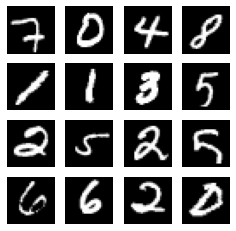

In [ ]:
from matplotlib import pyplot as plt
import numpy as np

def plot_grid_sample(size, data):
  fig = plt.gcf()
  fig.set_size_inches(size, size)
  cont = 1
  w = 4
  for ii in range(size):
    for jj in range(size):
        sp = plt.subplot(size, size, cont)
        sp.axis('Off')
        plt.imshow((np.squeeze(data[cont,:,:,:])), cmap='gray')
        cont+=1
  plt.show()

train_dataset = get_dataset(map_image)
X = next(iter(train_dataset))
print("Entradas")
print("Dimensão do batch: ", X.shape)
plot_grid_sample(4,X)


#2. Kullback–Leibler Divergence

Utilizaremos a divergencia KL entre distribuições normais (conforme ilustrado a seguir) para regularizar a loss do VAE com o objetivo de obter representações com média 0 e desvio padrão 1.

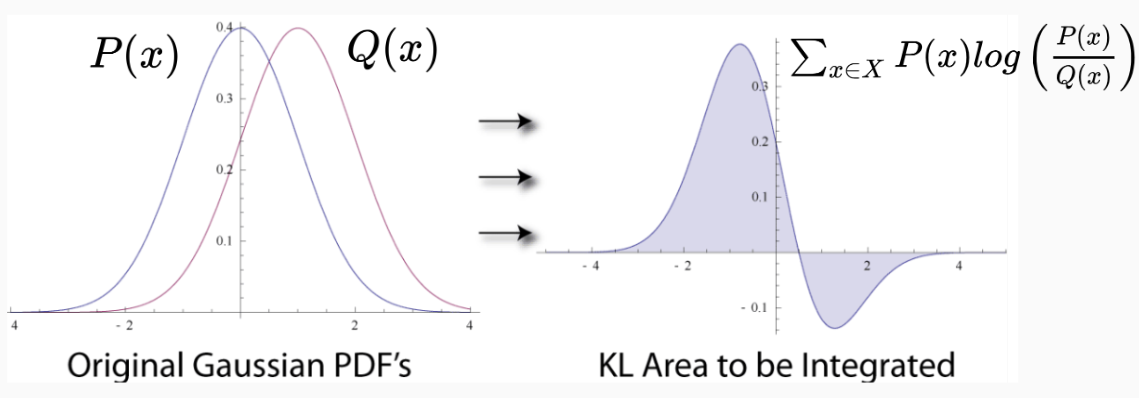

In [ ]:
def kl_reconstruction_loss(inputs, outputs, mu, sigma):
  """ Computes the Kullback-Leibler Divergence (KLD)
  Args:
    inputs -- batch from the dataset
    outputs -- output of the Sampling layer
    mu -- mean
    sigma -- standard deviation

  Returns:
    KLD loss
  """
  kl_loss = 1 + sigma - tf.square(mu) - tf.math.exp(sigma)
  kl_loss = tf.reduce_mean(kl_loss) * -0.5

  return kl_loss

#3. Construção do modelo

Conforme visto em sala de aula, o encoder do Variational Auto-Encoder (VAE) contém duas saídas: uma média $\mu$ e um desvio padrão $\sigma$. 

A imagem a seguir ilustra essa arquitetura. Logo a seguir, o respectivo código é apresentado:

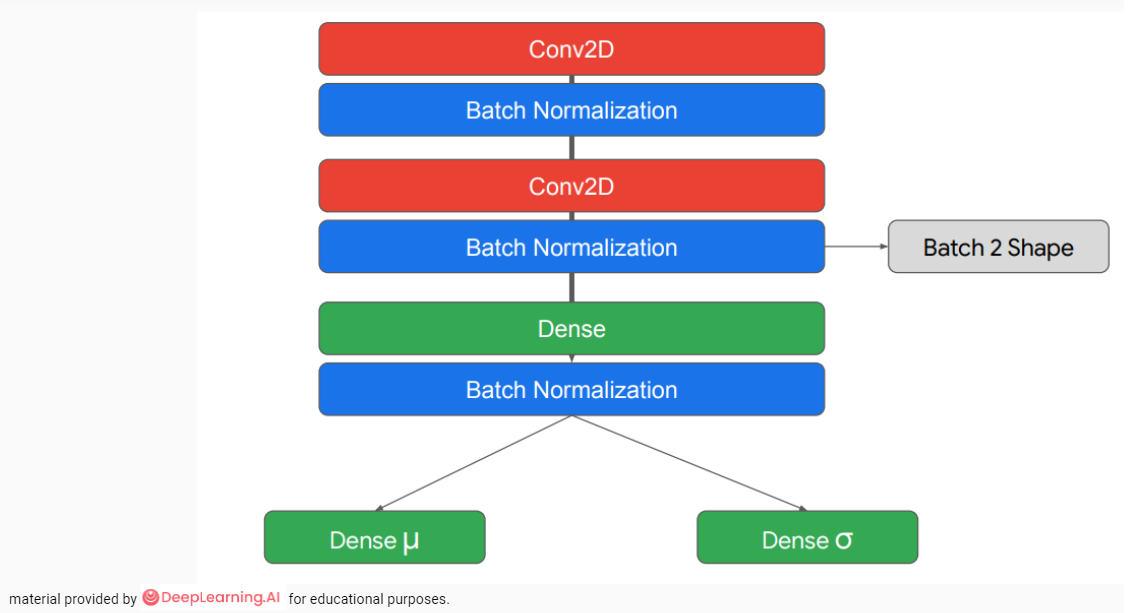

In [ ]:
#codigo sugeerido pelo Deep Learning AI para fins educacionais
def encoder_layers(inputs, latent_dim):
  """Defines the encoder's layers.
  Args:
    inputs -- batch from the dataset
    latent_dim -- dimensionality of the latent space

  Returns:
    mu -- learned mean
    sigma -- learned standard deviation
    batch_2.shape -- shape of the features before flattening
  """

  # add the Conv2D layers followed by BatchNormalization
  x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=2, padding="same", activation='relu', name="encode_conv1")(inputs)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=2, padding='same', activation='relu', name="encode_conv2")(x)

  # assign to a different variable so you can extract the shape later
  batch_2 = tf.keras.layers.BatchNormalization()(x)

  # flatten the features and feed into the Dense network
  x = tf.keras.layers.Flatten(name="encode_flatten")(batch_2)

  # we arbitrarily used 20 units here but feel free to change and see what results you get
  x = tf.keras.layers.Dense(20, activation='relu', name="encode_dense")(x)
  x = tf.keras.layers.BatchNormalization()(x)

  # add output Dense networks for mu and sigma, units equal to the declared latent_dim.
  mu = tf.keras.layers.Dense(latent_dim, name='latent_mu')(x)
  sigma = tf.keras.layers.Dense(latent_dim, name ='latent_sigma')(x)

  return mu, sigma, batch_2.shape

Em seguida, criamos o Layer *Sampling* que calculará o vetor $z$ no *latent space* como uma amostra de um $\mu$ e $\sigma$:

In [ ]:
#codigo sugeerido pelo Deep Learning AI para fins educacionais
class Sampling(tf.keras.layers.Layer):
  def call(self, inputs):
    """Generates a random sample and combines with the encoder output
    
    Args:
      inputs -- output tensor from the encoder

    Returns:
      `inputs` tensors combined with a random sample
    """

    # unpack the output of the encoder
    mu, sigma = inputs

    # get the size and dimensions of the batch
    batch = tf.shape(mu)[0]
    dim = tf.shape(mu)[1]

    # generate a random tensor
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))

    # combine the inputs and noise
    return mu + tf.exp(0.5 * sigma) * epsilon

Nesse momento, um modelo que representará todo *encoder* pode ser criado:

In [ ]:
#codigo sugeerido pelo Deep Learning AI para fins educacionais
def encoder_model(latent_dim, input_shape):
  """Defines the encoder model with the Sampling layer
  Args:
    latent_dim -- dimensionality of the latent space
    input_shape -- shape of the dataset batch

  Returns:
    model -- the encoder model
    conv_shape -- shape of the features before flattening
  """

  # declare the inputs tensor with the given shape
  inputs = tf.keras.layers.Input(shape=input_shape)

  # get the output of the encoder_layers() function
  mu, sigma, conv_shape = encoder_layers(inputs, latent_dim=LATENT_DIM)

  # feed mu and sigma to the Sampling layer
  z = Sampling()((mu, sigma))

  # build the whole encoder model
  model = tf.keras.Model(inputs, outputs=[mu, sigma, z])

  return model, conv_shape

Agora criamos um modelo *decoder* muito semelhante ao usado nos *Auto-Encoders* regulares:

In [ ]:
#codigo sugeerido pelo Deep Learning AI para fins educacionais
def decoder_layers(inputs, conv_shape):
  """Defines the decoder layers.
  Args:
    inputs -- output of the encoder 
    conv_shape -- shape of the features before flattening

  Returns:
    tensor containing the decoded output
  """

  # feed to a Dense network with units computed from the conv_shape dimensions
  units = conv_shape[1] * conv_shape[2] * conv_shape[3]
  x = tf.keras.layers.Dense(units, activation = 'relu', name="decode_dense1")(inputs)
  x = tf.keras.layers.BatchNormalization()(x)
  
  # reshape output using the conv_shape dimensions
  x = tf.keras.layers.Reshape((conv_shape[1], conv_shape[2], conv_shape[3]), name="decode_reshape")(x)

  # upsample the features back to the original dimensions
  x = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', activation='relu', name="decode_conv2d_2")(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu', name="decode_conv2d_3")(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=1, padding='same', activation='sigmoid', name="decode_final")(x)
  
  return x

def decoder_model(latent_dim, conv_shape):
  """Defines the decoder model.
  Args:
    latent_dim -- dimensionality of the latent space
    conv_shape -- shape of the features before flattening

  Returns:
    model -- the decoder model
  """

  # set the inputs to the shape of the latent space
  inputs = tf.keras.layers.Input(shape=(latent_dim,))

  # get the output of the decoder layers
  outputs = decoder_layers(inputs, conv_shape)

  # declare the inputs and outputs of the model
  model = tf.keras.Model(inputs, outputs)
  
  return model

Por fim, criamos o *Variational Auto-Encoder (VAE)* ilustrado a seguir:

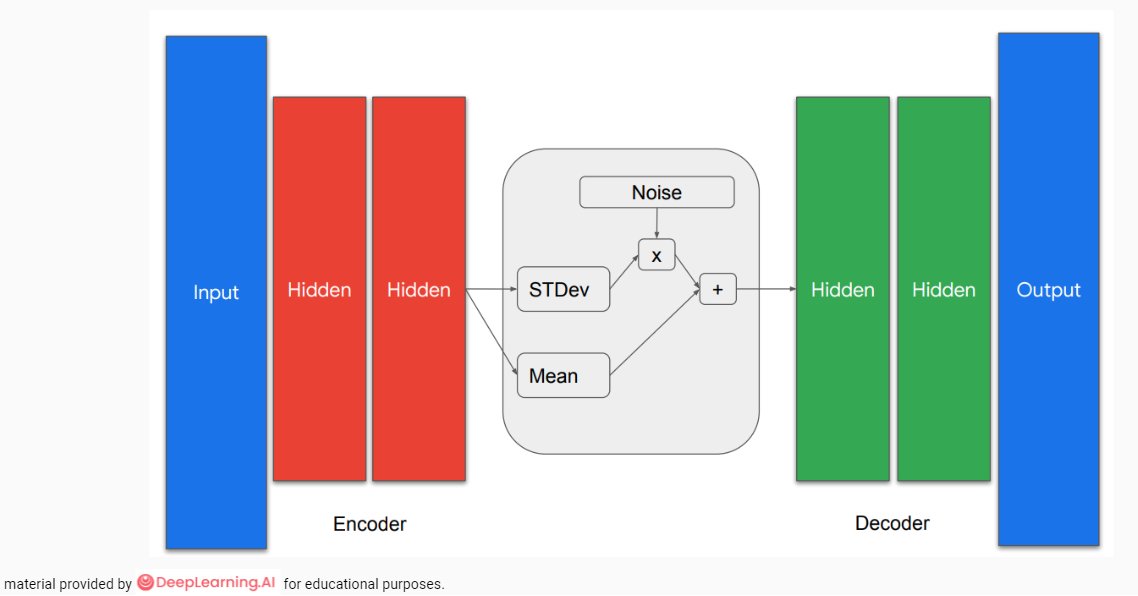

In [ ]:
#codigo sugerido pelo DeepLearning AI para fins educacionais
def vae_model(encoder, decoder, input_shape):
  """Defines the VAE model
  Args:
    encoder -- the encoder model
    decoder -- the decoder model
    input_shape -- shape of the dataset batch

  Returns:
    the complete VAE model
  """

  # set the inputs
  inputs = tf.keras.layers.Input(shape=input_shape)

  # get mu, sigma, and z from the encoder output
  mu, sigma, z = encoder(inputs)
  
  # get reconstructed output from the decoder
  reconstructed = decoder(z)

  # define the inputs and outputs of the VAE
  model = tf.keras.Model(inputs=inputs, outputs=reconstructed)

  # add the KL loss
  loss = kl_reconstruction_loss(inputs, decoder(z), mu, sigma)
  model.add_loss(loss)

  return model

In [ ]:
#codigo sugerido pelo DeepLearning AI para fins educacionais
def get_models(input_shape, latent_dim):
  """Returns the encoder, decoder, and vae models"""
  encoder, conv_shape = encoder_model(latent_dim=latent_dim, input_shape=input_shape)
  decoder = decoder_model(latent_dim=latent_dim, conv_shape=conv_shape)
  vae = vae_model(encoder, decoder, input_shape=input_shape)
  return encoder, decoder, vae



In [ ]:
encoder, decoder, vae = get_models(input_shape=(28,28,1,), latent_dim=LATENT_DIM)

#4. Treinamento do modelo

In [ ]:
#codigo sugerido pelo DeepLearning AI para fins educacionais
optimizer = tf.keras.optimizers.Adam()
loss_metric = tf.keras.metrics.Mean()
bce_loss = tf.keras.losses.BinaryCrossentropy()

In [ ]:
#codigo sugerido pelo DeepLearning AI para fins educacionais
def generate_and_save_images(model, epoch, step, test_input):
  """Helper function to plot our 16 images

  Args:

  model -- the decoder model
  epoch -- current epoch number during training
  step -- current step number during training
  test_input -- random tensor with shape (16, LATENT_DIM)
  """

  # generate images from the test input
  predictions = model.predict(test_input)

  # plot the results
  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0], cmap='gray')
      plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  fig.suptitle("epoch: {}, step: {}".format(epoch, step))
  plt.savefig('image_at_epoch_{:04d}_step{:04d}.png'.format(epoch, step))
  plt.show()

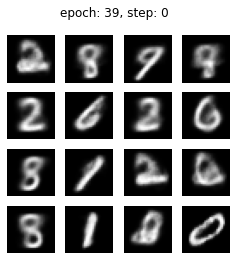

Epoch: 39 step: 0 mean loss = 150.04405


KeyboardInterrupt: ignored

In [ ]:
#codigo sugerido pelo DeepLearning AI para fins educacionais
# Training loop. 
from IPython import display
# generate random vector as test input to the decoder
random_vector_for_generation = tf.random.normal(shape=[16, LATENT_DIM])

# number of epochs
epochs = 100

# initialize the helper function to display outputs from an untrained model
generate_and_save_images(decoder, 0, 0, random_vector_for_generation)

for epoch in range(epochs):
  print('Start of epoch %d' % (epoch,))

  # iterate over the batches of the dataset.
  for step, x_batch_train in enumerate(train_dataset):
    with tf.GradientTape() as tape:

      # feed a batch to the VAE model
      reconstructed = vae(x_batch_train)

      # compute reconstruction loss
      flattened_inputs = tf.reshape(x_batch_train, shape=[-1])
      flattened_outputs = tf.reshape(reconstructed, shape=[-1])
      loss = bce_loss(flattened_inputs, flattened_outputs) * 784
      
      # add KLD regularization loss
      loss += sum(vae.losses)  

    # get the gradients and update the weights
    grads = tape.gradient(loss, vae.trainable_weights)
    optimizer.apply_gradients(zip(grads, vae.trainable_weights))

    # compute the loss metric
    loss_metric(loss)

    # display outputs every 100 steps
    if step % 100 == 0:
      display.clear_output(wait=False)    
      generate_and_save_images(decoder, epoch, step, random_vector_for_generation)
      print('Epoch: %s step: %s mean loss = %s' % (epoch, step, loss_metric.result().numpy()))

w
Latent vector (0.0,0.25)


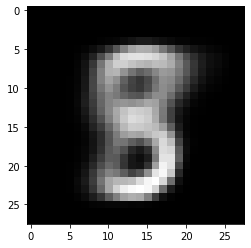

d
Latent vector (0.25,0.25)


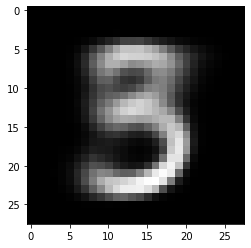

d
Latent vector (0.5,0.25)


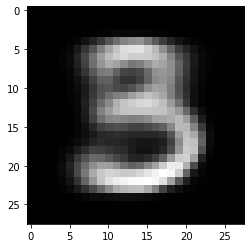

d
Latent vector (0.75,0.25)


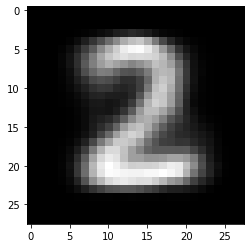

s
Latent vector (0.75,0.0)


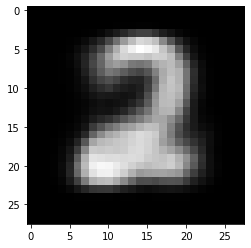

s
Latent vector (0.75,-0.25)


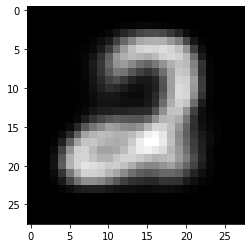

s
Latent vector (0.75,-0.5)


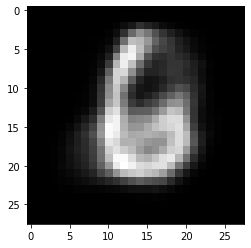

s
Latent vector (0.75,-0.75)


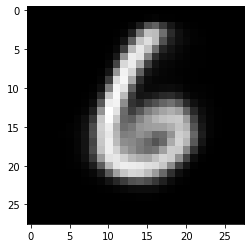

a
Latent vector (0.5,-0.75)


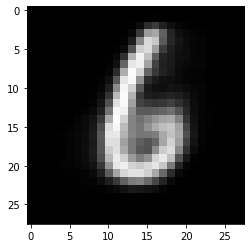

a
Latent vector (0.25,-0.75)


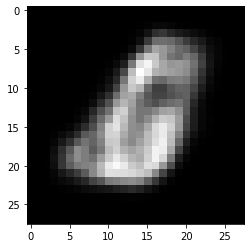

a
Latent vector (0.0,-0.75)


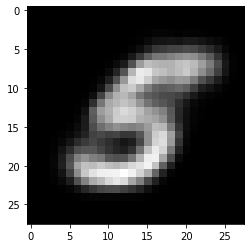

KeyboardInterrupt: ignored

In [ ]:
x, y = 0., 0.

keep_going = True
delta = 0.25

while keep_going:
  opt = input()
  if  opt == 'a':
    x = x - delta
  elif opt == 'd':
    x = x + delta
  elif opt == 'w':
    y = y + delta
  elif opt == 's':
    y = y - delta
  else:
    keep_going = False 

  print(f'Latent vector ({x},{y})')
  reconstructed = decoder(tf.constant([[x,y]]))

  plt.imshow(reconstructed[0,:,:,0], cmap='gray')
  plt.show()